# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'^GSPC': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'^GSPC': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,^GSPC_high,^GSPC_low,^GSPC_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1927-12-30,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-03,17.76,17.76,17.76,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-04,17.72,17.72,17.72,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-05,17.55,17.55,17.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-06,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,3179.78,3115.70,3152.05,167.45,164.60,167.17,170.64,168.78,169.63,167.45,164.60,167.17
2020-07-10,3186.82,3136.22,3185.04,168.21,166.16,166.33,170.15,168.57,169.19,168.21,166.16,166.33
2020-07-13,3235.32,3149.43,3155.22,166.96,165.23,166.88,170.42,169.16,169.40,166.96,165.23,166.88


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=1)
pf.TradeLog.instance

{'^GSPC': <pinkfish.trade.TradeLog at 0x7f492a5ae430>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f492a5ae460>,
 'GLD': <pinkfish.trade.TradeLog at 0x7f492a5ae490>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7f492a5ae4c0>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = portfolio.get_row_column_price(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,price,shares,entry_exit,direction,symbol
0,2004-12-01,1191.37,4,entry,LONG,^GSPC
1,2004-12-01,51.47,58,entry,LONG,TLT
2,2004-12-01,45.38,22,entry,LONG,GLD
3,2004-12-01,51.47,19,entry,SHRT,TLT_SHRT
4,2005-01-03,43.02,1,entry,LONG,GLD


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
174,2012-04-02,91.31,2017-09-01,118.57,-27.26,-27.26,1,10739.17,SHRT,TLT_SHRT
175,2012-04-02,91.31,2018-03-01,113.01,21.70,21.70,1,10760.86,LONG,TLT
176,2012-07-02,103.11,2018-04-02,115.68,12.58,25.16,2,10786.02,LONG,TLT
177,2012-07-02,103.11,2018-04-02,115.68,-12.58,-12.58,1,10773.44,SHRT,TLT_SHRT
178,2012-07-02,103.11,2018-06-01,114.70,11.60,11.60,1,10785.04,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
269,2020-04-01,2470.50,2020-07-15,3226.56,756.06,756.06,1,15149.59,LONG,^GSPC
270,2020-05-01,167.54,2020-07-15,166.34,-1.20,-3.59,3,15146.00,LONG,TLT
271,2020-05-01,167.54,2020-07-15,166.34,1.20,1.20,1,15147.20,SHRT,TLT_SHRT
272,2020-06-01,162.09,2020-07-15,166.34,4.25,12.75,3,15159.95,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-09,24947.13,24947.13,24947.13,77,4725.36,0.81,-
2020-07-10,25014.74,25014.74,25014.74,77,4725.36,0.81,-
2020-07-13,24944.72,24944.72,24944.72,77,4725.36,0.81,-
2020-07-14,25089.88,25089.88,25089.88,77,4725.36,0.81,-
2020-07-15,25155.70,25155.70,25155.70,0,25155.70,0.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2020-07-15
beginning_balance                                            10000
ending_balance                                            25155.70
total_net_profit                                          15155.70
gross_profit                                              18275.39
gross_loss                                                -3119.70
profit_factor                                                 5.86
return_on_initial_capital                                   151.56
annual_return_rate                                            6.07
trading_period                           15 years 7 months 27 days
pct_time_in_market                                           99.80
margin                                                           1
avg_leverage                                                  0.91
max_leverage                                                  

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-07-14 00:00:00 SELL 115 SPY @ 316.03


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

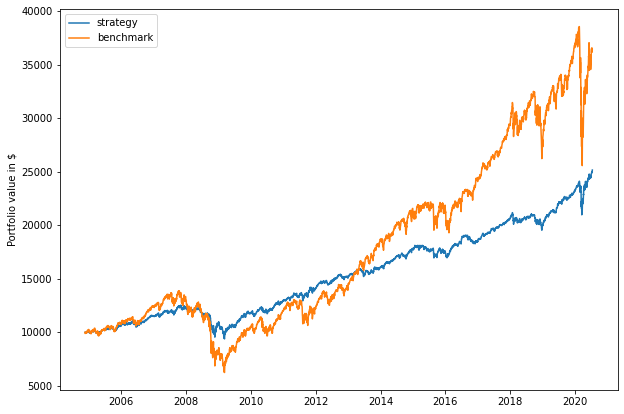

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

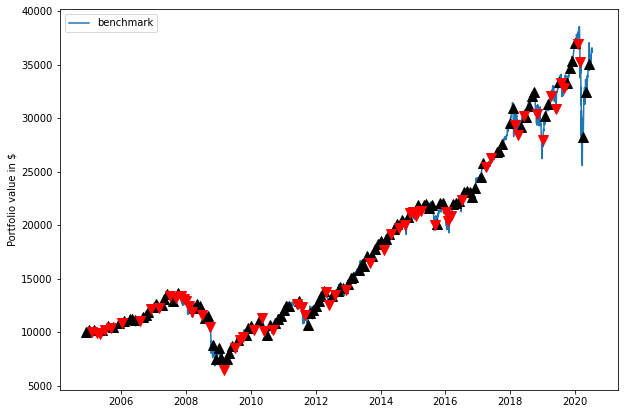

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$25,155.70","$36,385.19"
total_net_profit,"$15,155.70","$26,385.19"
gross_profit,"$18,275.39","$26,385.19"
gross_loss,"-$3,119.70",$0.00


,strategy,benchmark
annual_return_rate,6.07,8.60
max_closed_out_drawdown,-25.05,-55.02
drawdown_annualized_return,-4.13,-6.40
drawdown_recovery,-1.36,-1.42
best_month,12.85,23.46
worst_month,-13.00,-30.95
sharpe_ratio,0.77,0.52
sortino_ratio,0.99,0.62
monthly_std,2.03,4.57


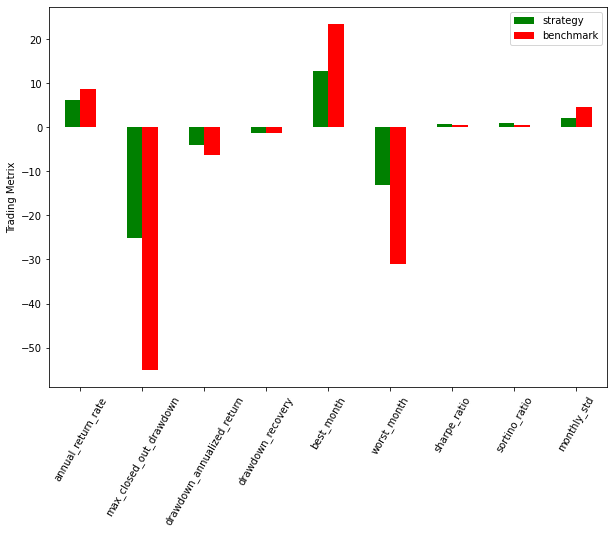

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df